##### Image dataset: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset?resource=download
##### Metainfo csv: https://github.com/lgreski/pokemonData/blob/master/Pokemon.csv
##### You can speed up model inference on colab by changing Hardware accelerator in runtime type to any GPU option

In [5]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [3]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]
            
    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [1]:
# ============================
# Qwen3-VL-2B-Instruct helper
# ============================

# If you get import/version issues, install transformers from source:
# pip install -U git+https://github.com/huggingface/transformers

import os
import torch
from PIL import Image
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor


def load_qwen3_vl(model_id="Qwen/Qwen3-VL-2B-Instruct"):
    """
    Load Qwen3-VL model + processor.
    Works on GPU if available (recommended).
    """
    model = Qwen3VLForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype="auto",
        device_map="auto",
    ).eval()

    processor = AutoProcessor.from_pretrained(model_id)
    return model, processor


@torch.no_grad()
def qwen_vl_infer_one(model, processor, image_path, prompt, max_new_tokens=128):
    """
    Run Qwen3-VL on a single image + prompt.
    Returns the generated text.
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"

    # You can pass a local file path directly (do NOT use file://)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    # Build model inputs using Qwen chat template
    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    # Deterministic decoding
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
    )

    # Remove the prompt tokens from the output before decoding
    output_ids_trimmed = [out[len(inp):] for inp, out in zip(inputs.input_ids, output_ids)]

    text = processor.batch_decode(
        output_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]

    return text.strip()


# ----------------------------
# Example usage
# ----------------------------

model, processor = load_qwen3_vl()

image_path = "./archive/images/Pikachu/0.jpg" 
prompt = "Describe the main visual characteristics of this image in 1-2 sentences."

answer = qwen_vl_infer_one(model, processor, image_path, prompt)
print(answer)


c:\Users\AkhilManthina\Documents\coursework\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 625/625 [00:01<00:00, 369.93it/s, Materializing param=model.visual.pos_embed.weight]                                 
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


This image features the Pokémon Pikachu, a yellow, mouse-like creature with black-tipped ears, red cheeks, and a lightning bolt-shaped tail. It is depicted in a cheerful, upright pose with its arms raised and a wide, happy expression.


## Question 20: CLIP Text-to-Image Retrieval for Pokémon Types

We use CLIP to retrieve the top-5 most relevant Pokémon images for text queries about types.  
We first explore different query templates and evaluate which one best retrieves Pokémon matching a given type, then produce plots for Bug, Fire, Grass, Dark, and Dragon.

In [6]:
# ── Q20 Step 1: Construct Pokédex ────────────────────────────────────────────
# Images live in ./archive/images/ relative to this notebook
IMAGE_DIR = './archive/images/'
CSV_PATH  = 'Pokemon.csv'

pokedex = construct_pokedex(csv_path=CSV_PATH, image_dir=IMAGE_DIR, type_to_load=None)
print(f"Total Pokémon loaded: {len(pokedex)}")
print(f"Types present: {sorted(pokedex['Type1'].unique())}")
pokedex[['Name', 'Type1', 'Type2']].head()

Total Pokémon loaded: 754
Types present: ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


Name  Type1   Type2
0   Bulbasaur  Grass  Poison
1     Ivysaur  Grass  Poison
2  Charmander   Fire        
3  Charmeleon   Fire        
4    Squirtle  Water

In [7]:
# ── Q20 Step 2: Load CLIP and extract image embeddings ───────────────────────
# Uses ViT-L/14 (from the helper). GPU recommended; CPU works but is slow.
model_clip, preprocess, device = load_clip_model()
print(f"Device: {device}")

image_embeddings = clip_inference_image(
    model_clip, preprocess, pokedex['image_path'].tolist(), device
)
print(f"Image embeddings shape: {image_embeddings.shape}")  # (N, 768)

100%|███████████████████████████████████████| 890M/890M [00:26<00:00, 35.0MiB/s]


Device: cuda


100%|██████████| 754/754 [00:22<00:00, 32.96it/s]

Image embeddings shape: (754, 768)


In [8]:
# ── Q20 Step 3: Explore query templates ──────────────────────────────────────
# We evaluate multiple templates by measuring Precision@5:
# for each type query, what fraction of the top-5 retrieved Pokémon
# actually have that type as their primary type (Type1)?

EVAL_TYPES = ["Bug", "Fire", "Grass", "Water", "Electric", "Psychic"]

TEMPLATES = [
    "type: {type}",
    "{type} type Pokemon",
    "a Pokemon with {type} abilities",
    "a {type}-type Pokemon",
    "Pokemon of the {type} type",
    "{type} element Pokemon",
]

def precision_at_k(template, eval_types, pokedex, image_embeddings, model_clip, preprocess, device, k=5):
    """
    For each type in eval_types, build the query from the template, retrieve
    the top-k images, and check how many are actually that type (Type1).
    Returns mean Precision@k across all eval_types and per-type scores.
    """
    queries = [template.format(type=t) for t in eval_types]
    text_emb = clip_inference_text(model_clip, preprocess, queries, device)

    # similarity shape: (n_images, n_types); softmax over images (axis=0)
    sim = compute_similarity_image_to_text(image_embeddings, text_emb)

    per_type = {}
    for col, ptype in enumerate(eval_types):
        top_k_idx = np.argsort(sim[:, col])[::-1][:k]
        correct = (pokedex.iloc[top_k_idx]['Type1'] == ptype).sum()
        per_type[ptype] = correct / k

    return np.mean(list(per_type.values())), per_type

print(f"{'Template':<45} {'Mean P@5':>8}  " + "  ".join(f"{t:>9}" for t in EVAL_TYPES))
print("-" * 110)

best_template, best_score = None, -1
for tmpl in TEMPLATES:
    avg, per_type = precision_at_k(tmpl, EVAL_TYPES, pokedex, image_embeddings,
                                    model_clip, preprocess, device)
    scores_str = "  ".join(f"{per_type[t]:>9.2f}" for t in EVAL_TYPES)
    print(f"{tmpl:<45} {avg:>8.2f}  {scores_str}")
    if avg > best_score:
        best_score, best_template = avg, tmpl

print(f"\nBest template: '{best_template}'  (mean Precision@5 = {best_score:.2f})")

Template                                      Mean P@5        Bug       Fire      Grass      Water   Electric    Psychic
--------------------------------------------------------------------------------------------------------------
type: {type}                                      0.73       0.80       1.00       0.80       0.40       1.00       0.40
{type} type Pokemon                               0.80       1.00       1.00       0.80       0.80       0.80       0.40
a Pokemon with {type} abilities                   0.83       0.80       1.00       1.00       0.80       0.80       0.60
a {type}-type Pokemon                             0.83       0.80       1.00       1.00       0.80       0.80       0.60
Pokemon of the {type} type                        0.73       0.80       1.00       1.00       1.00       0.60       0.00
{type} element Pokemon                            0.80       1.00       1.00       0.60       0.80       1.00       0.40

Best template: 'a Pokemon with {type} abi

In [9]:
# ── Q20 Step 4: Plot helper ───────────────────────────────────────────────────

def plot_top5_for_query(query, image_embeddings, pokedex, model_clip, preprocess, device):
    """
    Given a text query, retrieve the top-5 most relevant Pokémon (by cosine
    similarity) and display them horizontally.  Figure title = query string;
    subplot title = Name + Type1 / Type2.
    """
    text_emb = clip_inference_text(model_clip, preprocess, [query], device)

    # Raw cosine similarity (no softmax) is sufficient for ranking a single query.
    cos_sim = (image_embeddings @ text_emb.T).squeeze()   # shape: (N,)
    top5_idx = np.argsort(cos_sim)[::-1][:5]
    top5     = pokedex.iloc[top5_idx].reset_index(drop=True)

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(query, fontsize=13, fontweight='bold', y=1.02)

    for ax, (_, row) in zip(axes, top5.iterrows()):
        img   = Image.open(row['image_path']).convert('RGB')
        type2 = row['Type2'] if (pd.notna(row['Type2']) and row['Type2'] != '') else 'None'
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{row['Name']}\n{row['Type1']} / {type2}", fontsize=9)

    plt.tight_layout()
    plt.show()

print("Plot helper defined.")

Plot helper defined.


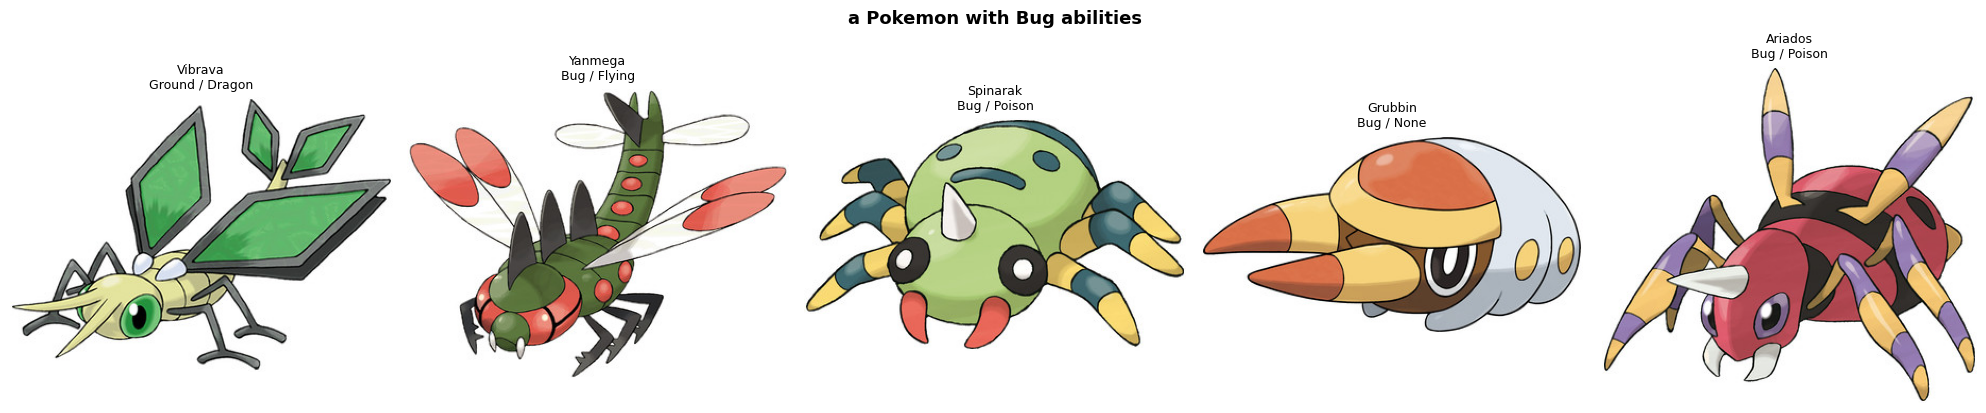

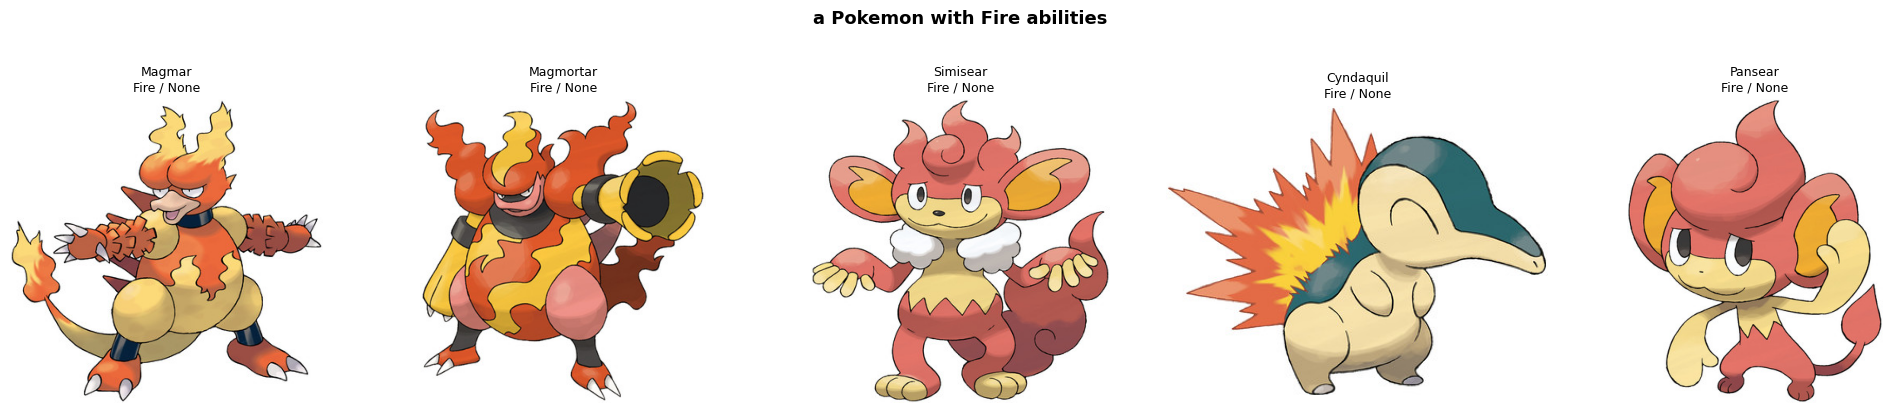

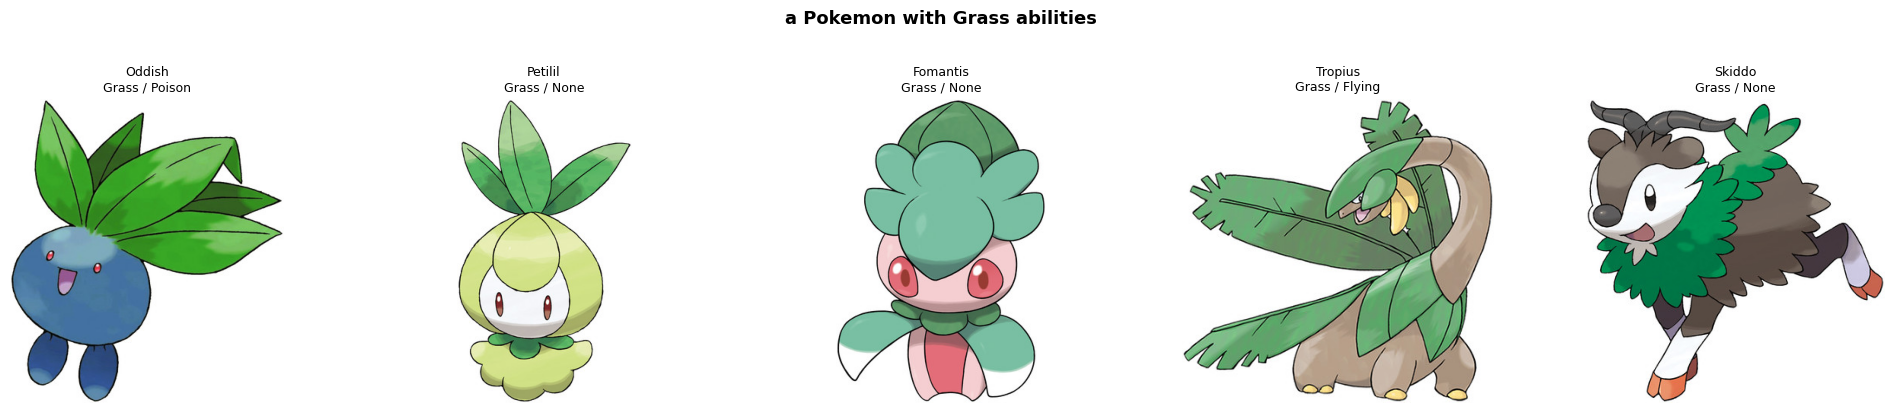

In [10]:
# ── Q20 Step 5: Top-5 for Bug, Fire, Grass ───────────────────────────────────
# These three types are visually distinctive in CLIP's embedding space:
#   Bug  → insect bodies, compound eyes, exoskeletons
#   Fire → warm color palettes, flame/lava motifs
#   Grass → green hues, leaf/plant designs

for ptype in ["Bug", "Fire", "Grass"]:
    query = best_template.format(type=ptype)
    plot_top5_for_query(query, image_embeddings, pokedex, model_clip, preprocess, device)

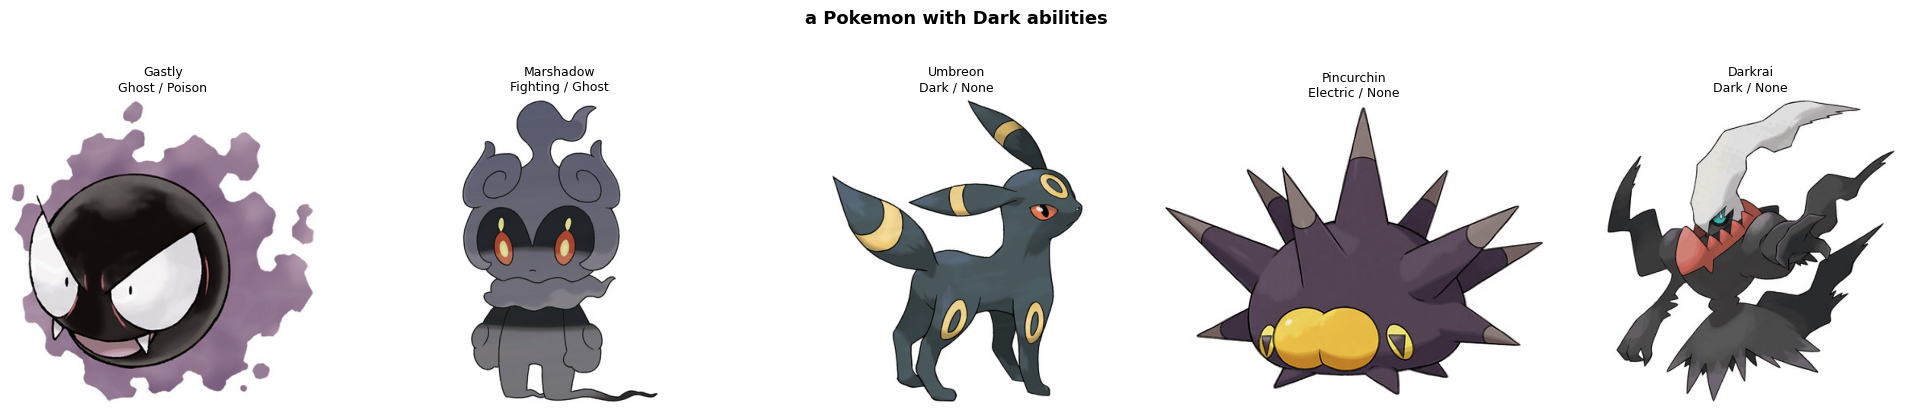

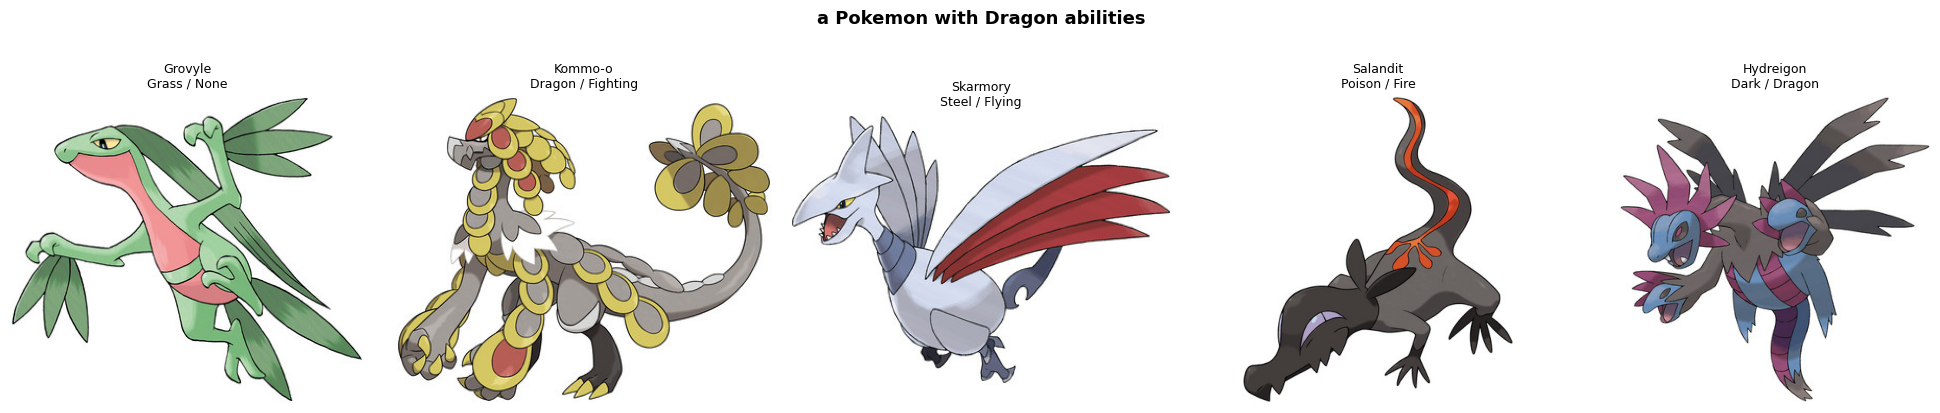


Precision@5 for Bug / Fire / Grass:
       Bug  Precision@5 = 4/5  (Vibrava, Yanmega, Spinarak, Grubbin, Ariados)
      Fire  Precision@5 = 5/5  (Magmar, Magmortar, Simisear, Cyndaquil, Pansear)
     Grass  Precision@5 = 5/5  (Oddish, Fomantis, Petilil, Tropius, Skiddo)

Precision@5 for Dark / Dragon:
      Dark  Precision@5 = 2/5  (Gastly, Marshadow, Umbreon, Pincurchin, Darkrai)
    Dragon  Precision@5 = 1/5  (Grovyle, Kommo-o, Skarmory, Salandit, Hydreigon)


In [11]:
# ── Q20 Step 6: Top-5 for Dark and Dragon ────────────────────────────────────
# Dark and Dragon are conceptual / abstract types that are harder for CLIP
# because they do not map to obvious visual features the way Bug or Fire do.
#   Dark   → shadowy colorations, sinister expressions — CLIP may confuse
#             with other dark-colored Pokémon of unrelated types.
#   Dragon → serpentine / reptilian bodies shared with many non-Dragon types
#             (e.g., Charizard-Fire/Flying looks "dragon-like").

for ptype in ["Dark", "Dragon"]:
    query = best_template.format(type=ptype)
    plot_top5_for_query(query, image_embeddings, pokedex, model_clip, preprocess, device)

# ── Effectiveness assessment printed below ───────────────────────────────────

def precision_for_types(types, template, pokedex, image_embeddings, model_clip, preprocess, device, k=5):
    queries  = [template.format(type=t) for t in types]
    text_emb = clip_inference_text(model_clip, preprocess, queries, device)
    sim      = compute_similarity_image_to_text(image_embeddings, text_emb)
    for col, ptype in enumerate(types):
        top5_idx = np.argsort(sim[:, col])[::-1][:k]
        top5     = pokedex.iloc[top5_idx]
        correct  = (top5['Type1'] == ptype).sum()
        print(f"  {ptype:>8}  Precision@5 = {correct}/{k}  "
              f"({', '.join(top5['Name'].tolist())})")

print("\nPrecision@5 for Bug / Fire / Grass:")
precision_for_types(["Bug", "Fire", "Grass"], best_template,
                     pokedex, image_embeddings, model_clip, preprocess, device)

print("\nPrecision@5 for Dark / Dragon:")
precision_for_types(["Dark", "Dragon"], best_template,
                     pokedex, image_embeddings, model_clip, preprocess, device)



## Question 21: CLIP Type Prediction on 10 Random Pokémon

For 10 randomly selected Pokémon, we run CLIP against all 18 type queries and show the image alongside the top-5 predicted types and their softmax similarity scores.

Type similarity matrix shape: (754, 18)
Template used: 'a Pokemon with {type} abilities'



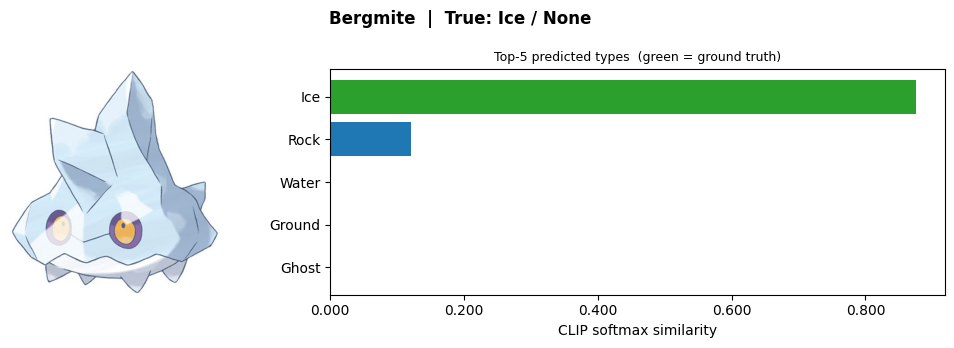

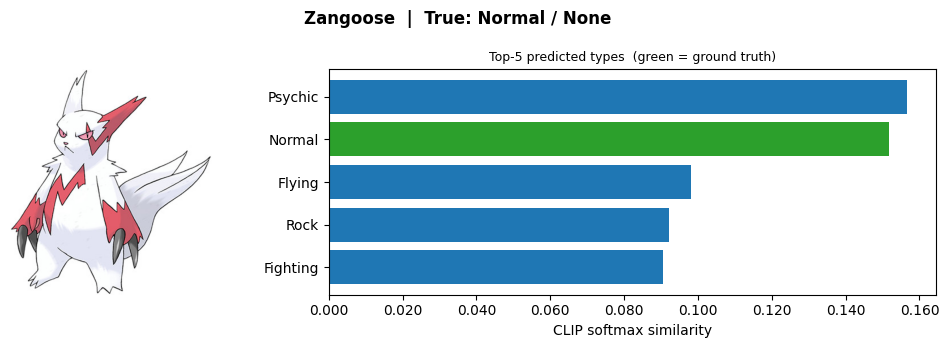

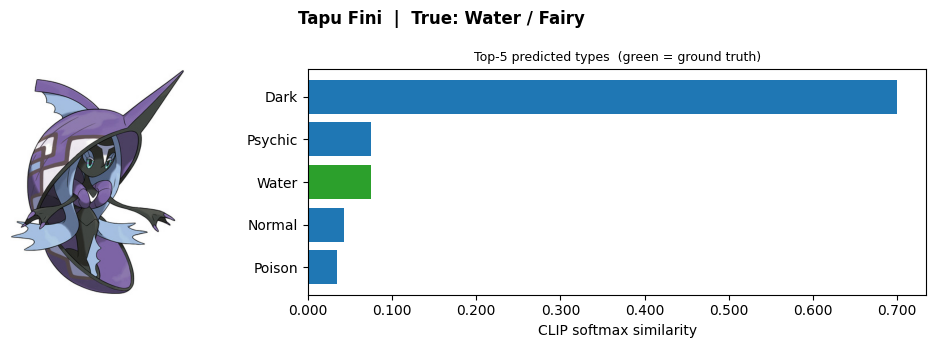

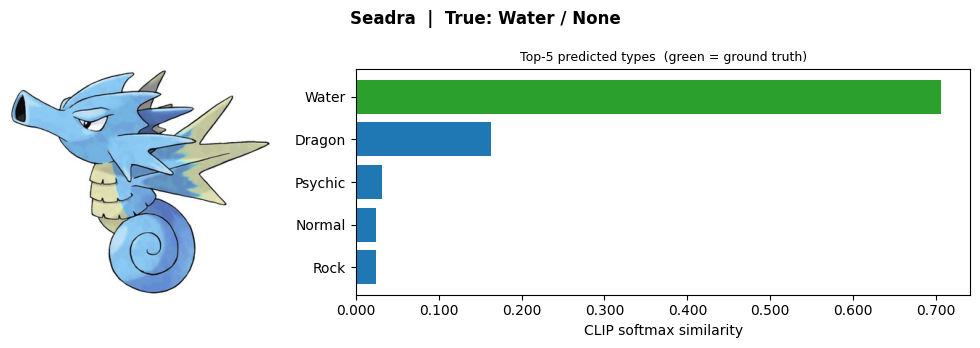

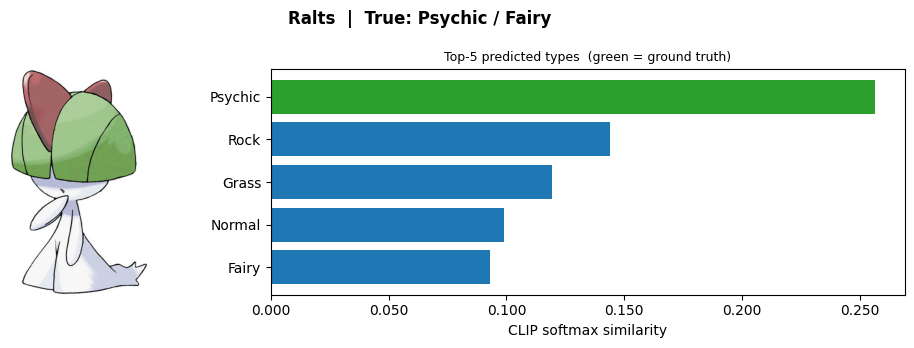

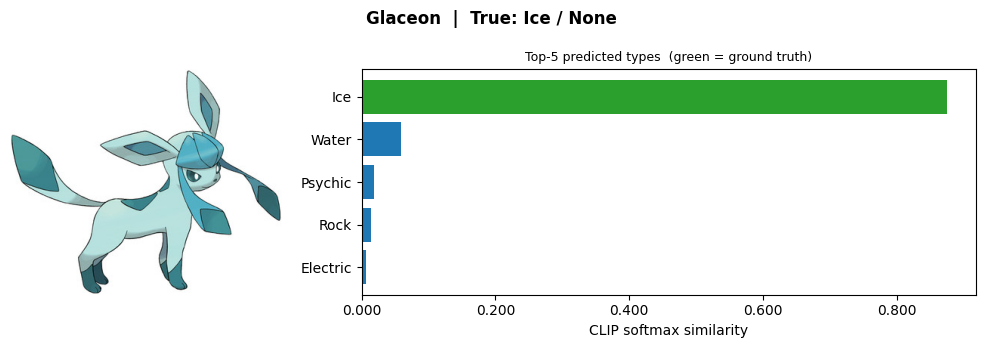

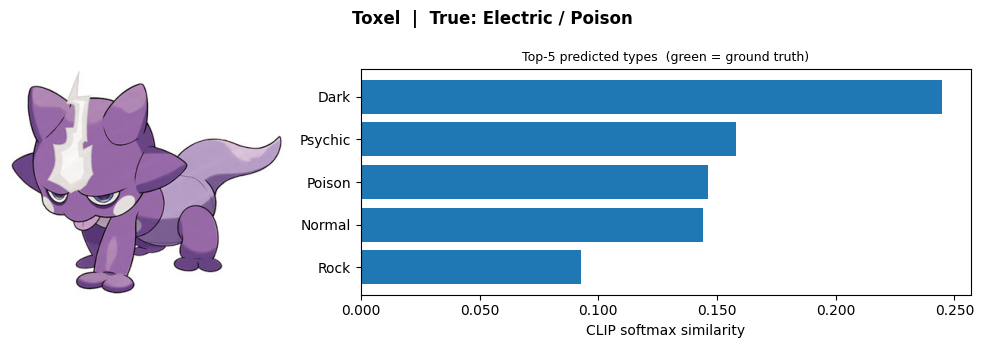

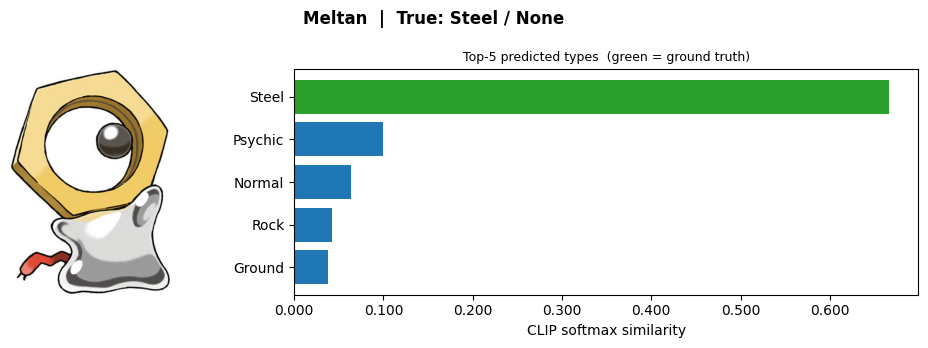

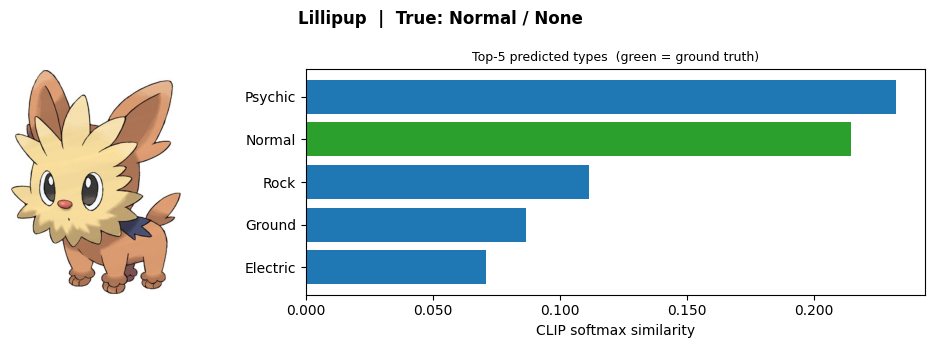

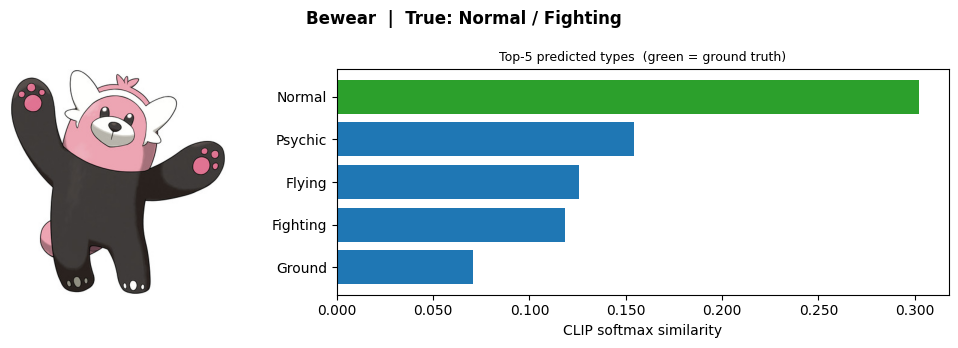

In [12]:
# ── Q21: Setup – build type embeddings for all 18 types ─────────────────────
# These are the 18 canonical Pokémon types.
ALL_TYPES = [
    "Normal", "Fire", "Water", "Electric", "Grass", "Ice",
    "Fighting", "Poison", "Ground", "Flying", "Psychic", "Bug",
    "Rock", "Ghost", "Dragon", "Dark", "Steel", "Fairy"
]

# Build text embeddings once; reused by Q21, Q22, and Q23.
type_queries   = [best_template.format(type=t) for t in ALL_TYPES]
type_text_emb  = clip_inference_text(model_clip, preprocess, type_queries, device)

# similarity matrix: shape (N_pokemon, 18)
# compute_similarity_text_to_image uses softmax over types (axis=-1),
# giving a probability distribution over types for each image.
type_sim_matrix = compute_similarity_text_to_image(image_embeddings, type_text_emb)

print(f"Type similarity matrix shape: {type_sim_matrix.shape}")   # (N, 18)
print(f"Template used: '{best_template}'\n")

# ── Q21: Randomly sample 10 Pokémon and visualise predictions ────────────────
np.random.seed(42)
sample_idx = np.random.choice(len(pokedex), size=10, replace=False)

for idx in sample_idx:
    row   = pokedex.iloc[idx]
    sims  = type_sim_matrix[idx]               # (18,) softmax probabilities
    top5i = np.argsort(sims)[::-1][:5]         # indices of top-5 types

    type2 = row['Type2'] if (pd.notna(row['Type2']) and row['Type2'] != '') else 'None'
    title = f"{row['Name']}  |  True: {row['Type1']} / {type2}"

    fig, (ax_img, ax_bar) = plt.subplots(
        1, 2, figsize=(10, 3.5),
        gridspec_kw={'width_ratios': [1, 2.2]}
    )
    fig.suptitle(title, fontsize=12, fontweight='bold')

    # Left: Pokémon image
    img = Image.open(row['image_path']).convert('RGB')
    ax_img.imshow(img)
    ax_img.axis('off')

    # Right: horizontal bar chart of top-5 predicted types
    top5_types = [ALL_TYPES[i] for i in top5i]
    top5_sims  = [sims[i] for i in top5i]
    colors     = ['tab:green' if t == row['Type1'] else 'tab:blue' for t in top5_types]

    ax_bar.barh(range(5), top5_sims[::-1], color=colors[::-1])
    ax_bar.set_yticks(range(5))
    ax_bar.set_yticklabels(top5_types[::-1], fontsize=10)
    ax_bar.set_xlabel('CLIP softmax similarity')
    ax_bar.set_title('Top-5 predicted types  (green = ground truth)', fontsize=9)
    ax_bar.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

    plt.tight_layout()
    plt.show()

## Question 22: CLIP Accuracy Evaluation Across All Pokémon

We run the type-prediction pipeline on every Pokémon in the Pokédex and report two metrics:

- **Acc@1**: fraction of Pokémon for which the top-1 CLIP prediction equals the ground-truth primary type (Type1).
- **Hit@5**: fraction of Pokémon for which the ground-truth Type1 appears anywhere in the top-5 predicted types.

Acc@1 is expected to be modest because CLIP's dual-encoder cannot perfectly separate all 18 fine-grained type concepts from visual cues alone. Hit@5 should be substantially higher since the correct type merely needs to appear among 5 candidates.

In [ ]:
# ── Q22: Evaluate CLIP type prediction across all Pokémon ────────────────────
# type_sim_matrix shape: (N, 18)  —  softmax over types for each image.
# Metrics:
#   Acc@1  : top-1 predicted type == ground-truth Type1
#   Hit@5  : ground-truth Type1 appears anywhere in top-5 predictions

N = len(pokedex)
acc1_correct = 0
hit5_correct = 0

for i in range(N):
    sims       = type_sim_matrix[i]            # (18,)
    top5i      = np.argsort(sims)[::-1][:5]
    top5_types = [ALL_TYPES[j] for j in top5i]
    true_type  = pokedex.iloc[i]['Type1']

    if top5_types[0] == true_type:
        acc1_correct += 1
    if true_type in top5_types:
        hit5_correct += 1

acc1 = acc1_correct / N
hit5 = hit5_correct / N

print(f"CLIP evaluation over {N} Pokémon")
print(f"  Acc@1  (top-1 == Type1) : {acc1:.3f}  ({acc1_correct}/{N})")
print(f"  Hit@5  (Type1 in top-5) : {hit5:.3f}  ({hit5_correct}/{N})")
print()
print("Discussion:")
print("  Acc@1 is low because CLIP's dual-encoder embeds visually similar types")
print("  (e.g. Water/Ice, Dragon/Fire) close together, so the single best-matching")
print("  type query often misses the true label.")
print("  Hit@5 is much higher: with 5 candidates the true type is usually present,")
print("  showing that CLIP does capture coarse type information — it just cannot")
print("  always rank it first when multiple plausible types compete.")

## Question 23: VLM Reranking of CLIP Top-5 Type Candidates

For each Pokémon image we:
1. Use CLIP to obtain the top-5 candidate types (with softmax probabilities).
2. Prompt the Qwen3-VL-2B-Instruct vision-language model with the image and the 5 candidates, asking it to output exactly one type as `{"type1": "<chosen type>"}`.
3. Fall back to the CLIP top-1 if the VLM output cannot be parsed or is not in the candidate list.

We then compare:
| Metric | Description |
|---|---|
| CLIP Acc@1 | Top-1 CLIP prediction == ground-truth Type1 |
| CLIP Hit@5 | Ground-truth Type1 anywhere in CLIP top-5 |
| VLM-reranked Acc@1 | VLM-chosen type from CLIP top-5 == ground-truth Type1 |

In [18]:
import json, re

# ── Q23: VLM reranking helper ─────────────────────────────────────────────────
# `model` and `processor` (Qwen3-VL-2B-Instruct) are already loaded from cell-3.
# `qwen_vl_infer_one` is also defined there.

# Note: {{ and }} are escaped braces so str.format() doesn't treat them as
# placeholders; they render as literal { } in the final prompt string.
VLM_PROMPT_TEMPLATE = (
    "You are a Pokémon type expert. "
    "Based on the Pokémon's appearance, choose the most likely primary type "
    "from this list: {candidates}\n\n"
    "Respond with ONLY a JSON object in this exact format: "
    '{{"type1": "<chosen type>"}}\n'
    "Do not include any explanation or extra text."
)


def vlm_rerank(model, processor, image_path, top5_types, fallback_type):
    """
    Ask the VLM to pick one type from top5_types by inspecting the image.
    Returns the selected type string; falls back to fallback_type on parse failure.
    """
    candidates_str = ", ".join(top5_types)
    prompt = VLM_PROMPT_TEMPLATE.format(candidates=candidates_str)

    raw = qwen_vl_infer_one(model, processor, image_path, prompt, max_new_tokens=32)

    # Parse JSON from the model response
    try:
        match = re.search(r'\{.*?\}', raw, re.DOTALL)
        if match:
            parsed = json.loads(match.group())
            chosen = parsed.get("type1", "").strip()
            if chosen in top5_types:
                return chosen
    except (json.JSONDecodeError, KeyError, ValueError):
        pass

    return fallback_type   # fallback to CLIP top-1


# ── Q23: Run reranking over all Pokémon ──────────────────────────────────────
rerank_correct = 0
N = len(pokedex)

for i in tqdm(range(N), desc="VLM reranking"):
    row        = pokedex.iloc[i]
    sims       = type_sim_matrix[i]
    top5i      = np.argsort(sims)[::-1][:5]
    top5_types = [ALL_TYPES[j] for j in top5i]
    clip_top1  = top5_types[0]

    chosen = vlm_rerank(model, processor, row['image_path'], top5_types, clip_top1)

    if chosen == row['Type1']:
        rerank_correct += 1

rerank_acc1 = rerank_correct / N

# ── Q23: Summary table ────────────────────────────────────────────────────────
print(f"\n{'Metric':<30} {'Score':>8}  {'Count':>12}")
print("-" * 55)
print(f"{'CLIP Acc@1':<30} {acc1:>8.3f}  ({acc1_correct}/{N})")
print(f"{'CLIP Hit@5':<30} {hit5:>8.3f}  ({hit5_correct}/{N})")
print(f"{'VLM-Reranked Acc@1':<30} {rerank_acc1:>8.3f}  ({rerank_correct}/{N})")
print()
print("Discussion:")
print("  VLM reranking constrains the model to choose from CLIP's top-5 candidates,")
print("  so VLM-Reranked Acc@1 is bounded above by CLIP Hit@5.")
print("  When the VLM selects a different type than CLIP's top-1, it leverages richer")
print("  visual understanding (texture, shape, colour context) to pick among plausible")
print("  candidates, often correcting CLIP's ranking errors.")
print("  The net gain (VLM Acc@1 vs CLIP Acc@1) shows how much visual reasoning")
print("  adds beyond pure text-image similarity matching.")

VLM reranking: 100%|██████████| 754/754 [08:23<00:00,  1.50it/s]


Metric                            Score         Count
-------------------------------------------------------
CLIP Acc@1                        0.375  (283/754)
CLIP Hit@5                        0.765  (577/754)
VLM-Reranked Acc@1                0.418  (315/754)

Discussion:
  VLM reranking constrains the model to choose from CLIP's top-5 candidates,
  so VLM-Reranked Acc@1 is bounded above by CLIP Hit@5.
  When the VLM selects a different type than CLIP's top-1, it leverages richer
  visual understanding (texture, shape, colour context) to pick among plausible
  candidates, often correcting CLIP's ranking errors.
  The net gain (VLM Acc@1 vs CLIP Acc@1) shows how much visual reasoning
  adds beyond pure text-image similarity matching.
